### Meta-connectivity analysis

In [1]:
# Path to the toolbox
import sys; sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')
import os 

# GDa functions
import GDa.stats.bursting                as     bst
from   GDa.session                       import session
from   GDa.temporal_network              import temporal_network

import matplotlib.pyplot                 as     plt
import matplotlib
import GDa.graphics.plot                 as     plot
import seaborn                           as     sns

from   mne.viz                           import circular_layout, \
                                                plot_connectivity_circle

import numpy                             as     np
import pandas                            as     pd
import xarray                            as     xr
import brainconn                         as     bc

from   tqdm                              import tqdm
from   sklearn.manifold                  import TSNE
from   scipy                             import stats

In [2]:
# Extract area names
def _extract_roi(roi, sep):
    # Code by Etiene
    x_s, x_t = [], []
    for r in roi:
        _x_s, _x_t = r.split(sep)
        x_s.append(_x_s), x_t.append(_x_t)
    roi_c = np.c_[x_s, x_t]
    idx = np.argsort(np.char.lower(roi_c.astype(str)), axis=1)
    roi_s, roi_t = np.c_[[r[i] for r, i in zip(roi_c, idx)]].T
    roi_st = [f"{s}{sep}{t}" for s, t in zip(roi_s, roi_t)]
    return roi_s, roi_t, roi_st

#### Plotting and file saving configurations

In [3]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = plot.set_plot_config()

In [4]:
# Create directory to save figures
if not os.path.exists("img/n5.0.2"):
    os.makedirs("img/n5.0.2")

In [5]:
# Bands names
band_names  = [r'band 1', r'band 2', r'band 3', r'band 4', r'band 5']
stages      = ['baseline', 'cue', 'delay', 'match']
_stats      = [r"$\mu$","std$_{\mu}$",r"$\mu_{tot}$","CV"]

In [6]:
### Methods to read coherence files
def get_coh_file(ks=None, surr=False, mode="morlet"):
    _COH_FILE = f'super_tensor_k_{ks}_surr_{surr}_{mode}.nc'
    return _COH_FILE

In [7]:
# Parameters to read the data
idx      = 3 
nses     = 1
nmonkey  = 0
align_to = 'cue'

dirs = { 'rawdata':'/home/vinicius/storage1/projects/GrayData-Analysis/GrayLab',
         'results':'Results/',
         'monkey' :['lucy', 'ethyl'],
         'session':'session01',
         'date'   :[['141014', '141015', '141205', '150128', '150211', '150304'], []] }

In [8]:
###################################################################################
# Instantiate network to get parameters
###################################################################################

net =  temporal_network(coh_file=get_coh_file(ks=500, surr=False, mode="morlet"), monkey=dirs['monkey'][nmonkey], 
                        session=1, date='150128', trial_type=[1],
                        behavioral_response=[1], wt=(20,20), drop_trials_after=True,
                        verbose=True, q=None)

### Computing MC

In [277]:
import numba as nb

In [278]:
def cross_correlation(data):
    cc = np.corrcoef(data)
    np.fill_diagonal(cc, 0)
    return cc

def return_MC(_surr=False, verbose=False):
    # Instantiating a temporal network object without thresholding the data
    net =  temporal_network(coh_file=get_coh_file(ks=500, surr=_surr, mode="morlet"), monkey=dirs['monkey'][nmonkey], 
                            session=1, date='150128', trial_type=[1],
                            behavioral_response=[1], wt=(20,20), drop_trials_after=True,
                            verbose=True, q=None, relative=False)
    
    MC   = np.empty((net.super_tensor.sizes["roi"],net.super_tensor.sizes["roi"],net.super_tensor.sizes["freqs"],len(stages)))
    
    _iter = range( net.super_tensor.sizes["freqs"] )
    for f in (tqdm(_iter) if verbose else _iter ):
        for stage in range( len(stages) ):
            MC[...,f,stage]=cross_correlation(net.get_data_from(stage=stages[stage]).isel(freqs=f))
            
    roi_st = [f"{s}-{t}" for s, t in zip(net.super_tensor.attrs["sources"], net.super_tensor.attrs["targets"])]
            
    MC = xr.DataArray(MC, dims=("roi_1","roi_2","freqs","stages"),
                      coords={"roi_1": roi_st,
                              "roi_2": roi_st,
                              "freqs": net.super_tensor.freqs.values,
                              "stages": stages
                             })
    
    # Computes modularity and affiliation vector for each frequency and stage
    aff = np.zeros((net.super_tensor.sizes["roi"],net.super_tensor.sizes["freqs"],len(stages)))
    Q   = np.zeros((net.super_tensor.sizes["freqs"],len(stages)))
    _iter = range( net.super_tensor.sizes["freqs"] )
    for f in (tqdm(_iter) if verbose else _iter ):
        for stage in range( len(stages) ):
            aff[:,f,stage], Q[f,stage] = bc.modularity.modularity_finetune_und_sign(MC.isel(freqs=f,stages=stage).values,qtype="sta", seed=0)
            
    MC.attrs["aff"] = aff
    MC.attrs["Q"]   = Q
            
    return MC

In [279]:
MC      = return_MC(_surr=False, verbose=True)
MC_surr = return_MC(_surr=True,  verbose=True)

100%|██████████| 5/5 [00:28<00:00,  5.61s/it]


In [291]:
_FREQ = 1

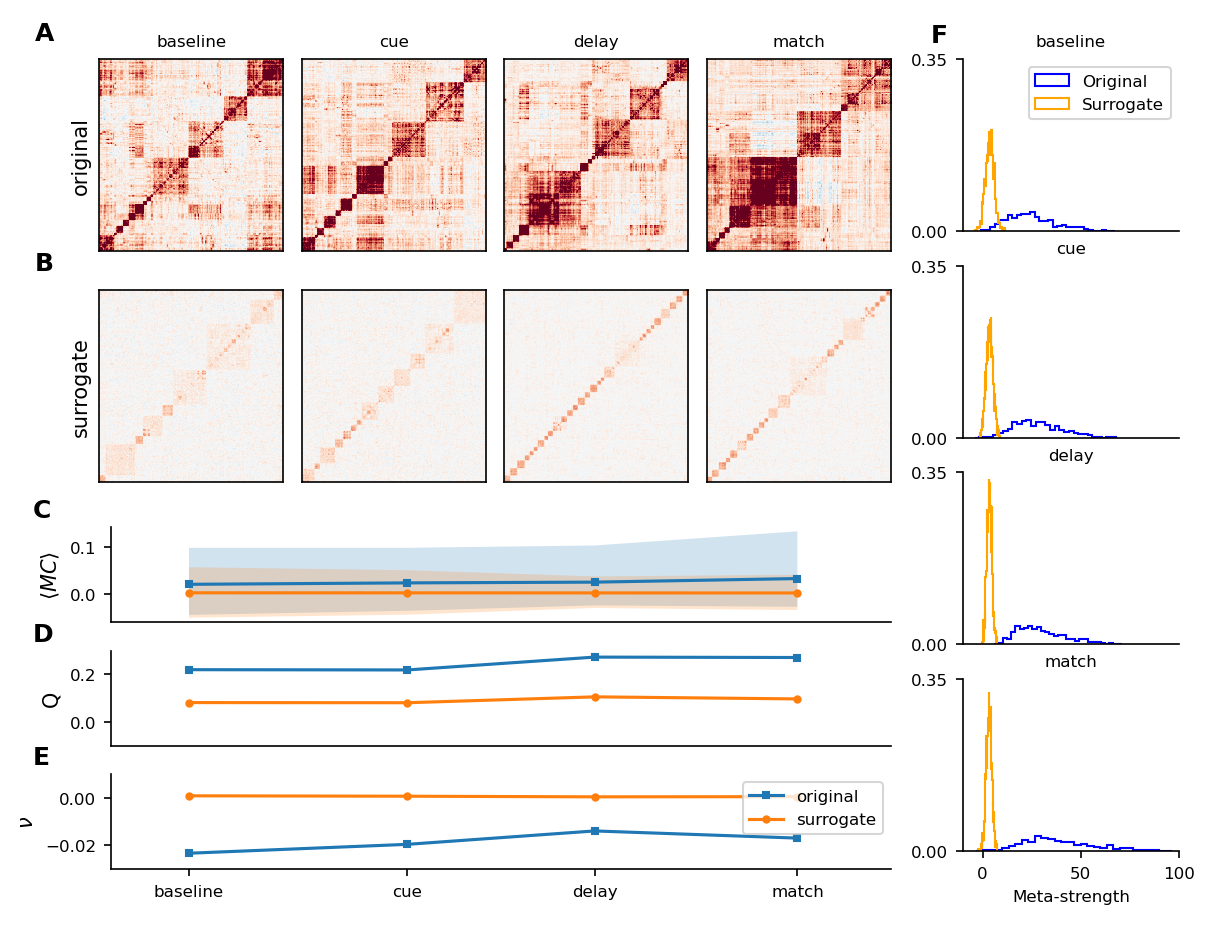

In [292]:
fig = plt.figure(figsize=(8, 6), dpi=150)

gs1 = fig.add_gridspec(nrows=2, ncols=4, left=0.07, right=0.73, bottom=0.48, top=0.95, wspace=.1)
gs2 = fig.add_gridspec(nrows=3, ncols=1, left=0.08, right=0.73, bottom=0.05, top=0.43, wspace=.1, hspace=.3)
gs3 = fig.add_gridspec(nrows=4, ncols=1, left=0.79, right=0.97, bottom=0.07, top=0.95, wspace=.1)


# Panel A
ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
ax3 = plt.subplot(gs1[2])
ax4 = plt.subplot(gs1[3])
ax5 = plt.subplot(gs1[4])
ax6 = plt.subplot(gs1[5])
ax7 = plt.subplot(gs1[6])
ax8 = plt.subplot(gs1[7])

vmin=-0.1
vmax=0.1

ax_list = fig.get_axes()
or_axes = [0,1,2,3]
sr_axes = [4,5,6,7]

for i, ax_i in enumerate( or_axes ):
    plt.sca(ax_list[ax_i])
    ii = np.argsort(MC.attrs["aff"][:,_FREQ,i])
    plt.imshow(MC.isel(freqs=_FREQ,stages=i).values[np.ix_(ii,ii)],aspect="auto",cmap="RdBu_r", origin="lower",vmin=vmin,vmax=vmax)
    plt.xticks([])
    plt.yticks([])
    plt.title(stages[i])
    if i==0: plt.ylabel("original")
    
for i, ax_i in enumerate( sr_axes ):
    plt.sca(ax_list[ax_i])
    ii = np.argsort(MC_surr.attrs["aff"][:,_FREQ,i])
    plt.imshow(MC_surr.isel(freqs=_FREQ,stages=i).values[np.ix_(ii,ii)],aspect="auto",cmap="RdBu_r", origin="lower",vmin=vmin,vmax=vmax)
    plt.xticks([])
    plt.yticks([])
    if i==0: plt.ylabel("surrogate")
    
    
# Panels C
ax10 = plt.subplot(gs2[0])
ax11 = plt.subplot(gs2[1])
ax12 = plt.subplot(gs2[2])

quantiles=[[0.05, 0.95],[0.05, 0.95],[0.05, 0.95],[0.05, 0.95]]

ax_list = fig.get_axes()

for i, ax_i in enumerate([8,9,10]):
    ax_list[ax_i].spines["top"].set_visible(False)
    ax_list[ax_i].spines["right"].set_visible(False)

_x = [0.1,0.38,0.62,0.88]    

#################################################################
# Mean meta-connectivity
#################################################################
plt.sca(ax10)
avg_MC = MC.isel(freqs=_FREQ).mean(axis=(0,1))
MCq05  = MC.isel(freqs=_FREQ).quantile(5/100, dim=("roi_1","roi_2"))
MCq95  = MC.isel(freqs=_FREQ).quantile(95/100, dim=("roi_1","roi_2"))
plt.plot(_x, avg_MC, 's-', ms=3)
plt.fill_between(_x, MCq05, MCq95, alpha=0.2)
avg_MC_surr = MC_surr.isel(freqs=_FREQ).mean(axis=(0,1))
MCq05_surr  = MC_surr.isel(freqs=_FREQ).quantile(5/100, dim=("roi_1","roi_2"))
MCq95_surr  = MC_surr.isel(freqs=_FREQ).quantile(95/100, dim=("roi_1","roi_2"))
plt.plot(_x, avg_MC_surr, 'o-', ms=3)
plt.fill_between(_x, MCq05_surr, MCq95_surr, alpha=0.2)
plt.ylabel(r"$\langle MC \rangle$")
#ax10.spines["bottom"].set_visible(False)
plt.xticks([])
plt.xlim([0,1])


#################################################################
# Modularity
#################################################################
plt.sca(ax11)
plt.plot(_x, MC.attrs["Q"][_FREQ], 's-', ms=3)
plt.plot(_x, MC_surr.attrs["Q"][_FREQ], 'o-', ms=3)
plt.ylabel("Q")
#ax11.spines["bottom"].set_visible(False)
plt.xticks([])
plt.xlim([0,1])
plt.ylim([-0.1,0.3])

#################################################################
# Viscosity
#################################################################
visc      = MC.where(MC<0).isel(freqs=_FREQ).mean(dim=("roi_1","roi_2"))
visc_surr = MC_surr.where(MC<0).isel(freqs=_FREQ).mean(dim=("roi_1","roi_2"))

plt.sca(ax12)
plt.plot(_x, visc, 's-', ms=3)
plt.plot(_x, visc_surr, 'o-', ms=3)
plt.ylabel(r"$\nu$")
#ax12.spines["bottom"].set_visible(False)
plt.xticks(_x, stages)
plt.xlim([0,1])
plt.ylim([-0.03,0.01])
plt.legend(["original","surrogate"], fontsize=SMALL_SIZE, loc='upper right')

# Panels B
ax13 = plt.subplot(gs3[0])
ax14 = plt.subplot(gs3[1])
ax15 = plt.subplot(gs3[2])
ax16 = plt.subplot(gs3[3])

ax_list = fig.get_axes()

for i, ax_i in enumerate([11,12,13,14]):
    plt.sca(ax_list[ax_i])
    plt.hist(MC.isel(freqs=_FREQ, stages=i).sum(axis=1), bins=30, density=True, 
             lw=1, histtype='step', fill=False, color="b",orientation="vertical")
    plt.hist(MC_surr.isel(freqs=_FREQ, stages=i).sum(axis=1), bins=50, density=True, 
             lw=1, histtype='step', fill=False, color="orange",orientation="vertical")
    if i==0: plt.legend(["Original", "Surrogate"], fontsize=SMALL_SIZE)
    if i<3:
        plt.xticks([])
    if i==3:
        plt.xlabel("Meta-strength", fontsize=SMALL_SIZE)
    plt.xlim([-10,100])
    plt.ylim([0,.35])
    plt.yticks([0,.35])
    ax_list[ax_i].spines["right"].set_visible(False)
    ax_list[ax_i].spines["top"].set_visible(False)
    plt.title(stages[i])
    
plot.add_panel_letters(fig, axes=[ax1, ax5, ax10, ax11, ax12, ax13], fontsize=12,
                           xpos=[-0.35,-0.35,-0.1,-0.1,-0.1,-0.15], ypos=[1.1, 1.1, 1.1, 1.1, 1.1, 1.1]);

bg = plot.Background(visible=False)

plt.savefig(f"img/n5.0.2/meta_conn_stats_f_{_FREQ}.png")

### MC spatial structure

In [293]:
#@nb.jit(nopython=True)
def compute_trimer_st(MC, x_s, x_t, av=None):
    
    # Get number of rois based on source/targets arrays
    n_rois  = np.concatenate((x_s,x_t)).astype(int).max()+1
    
    # If a affiliation vector is passed compute trimer-strengths
    # per module
    if av is not None:
        # Number of modules
        n_mods = av.max()
        ts     = np.zeros((n_mods,n_rois))
        for m in range(1,av.max()+1):
            # Get indexes of nodes inside module m
            i_m = (av==m)
            sources, targets = x_s[i_m], x_t[i_m]
            for i in range(n_rois):
                idx     = np.logical_or(sources==f"{i}", targets==f"{i}")
                ts[m-1,i] = MC[np.ix_(idx,idx)].sum()
    # Otherwise compute for each roi
    else:
        ts = np.zeros(n_rois)
        for i in range(n_rois):
            idx   = np.logical_or(x_s==f"{i}", x_t==f"{i}")
            ts[i] = MC[np.ix_(idx,idx)].sum()
    return ts

In [301]:
x_s, x_t, _ = _extract_roi(MC.roi_1.values, "-")
A           = MC.isel(freqs=1,stages=2).values
av, Q = bc.modularity.modularity_finetune_und_sign(A, qtype="sta", seed=0)
Tst         = compute_trimer_st(A, x_s, x_t, av)

In [302]:
sorted_roi     = np.sort(net.super_tensor.attrs["areas"])
sorted_roi_idx = np.argsort(net.super_tensor.attrs["areas"]) 

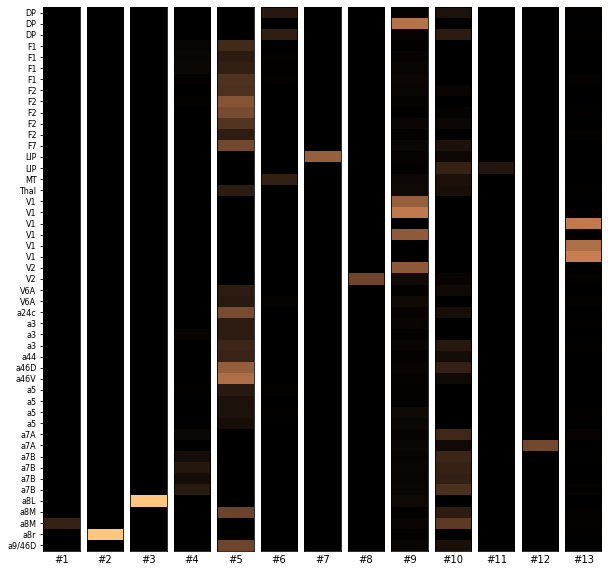

In [303]:
plt.figure(figsize=(10,10))
for i in range(Tst.shape[0]):
    plt.subplot(1,Tst.shape[0],i+1)
    plt.imshow(Tst[i,sorted_roi_idx][:,None], aspect="auto", cmap="copper", vmax=180, vmin=0)
    if i>0:  plt.yticks([])
    if i==0: plt.yticks(range(49), sorted_roi)
    plt.xlabel(f"#{i+1}")
    plt.xticks([])

In [304]:
Q

0.2721865373902688

##########################################################################

In [63]:
data = np.random.normal(0,1,size=(4,1000))
data = (data-data.mean(-1)[:,None])/data.std(-1)[:,None]

In [64]:
x_s, x_t = np.triu_indices(4, k=1)
dFC      = np.zeros((len(x_s),1000))

In [65]:
plt.imshow(Tst_mod[7][:,None], aspect="auto")for p,(i,j) in enumerate( zip(x_s,x_t) ):
    dFC[p] = data[i]*data[j]

In [66]:
aux = np.corrcoef(dFC)
np.fill_diagonal(aux,0)

In [67]:
roi_st = [f"{s}-{t}" for s, t in zip(x_s, x_t)]

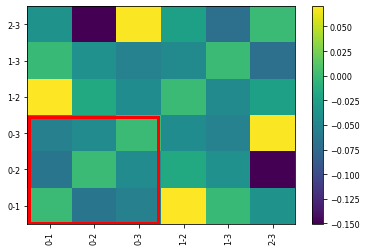

In [86]:
plt.imshow(aux, aspect="auto", cmap="viridis", origin="lower")
rect = patches.Rectangle((-.47,-.47), 2.9, 2.9, color='r',fill=False, lw=3)
plt.gca().add_patch(rect)
plt.xticks(range(6),roi_st, rotation=90)
plt.yticks(range(6),roi_st)
plt.colorbar()

In [59]:
from matplotlib import patches

In [61]:
patches.Rectangle?

Init signature: patches.Rectangle(xy, width, height, angle=0.0, **kwargs)
Docstring:     
A rectangle defined via an anchor point *xy* and its *width* and *height*.

The rectangle extends from ``xy[0]`` to ``xy[0] + width`` in x-direction
and from ``xy[1]`` to ``xy[1] + height`` in y-direction. ::

  :                +------------------+
  :                |                  |
  :              height               |
  :                |                  |
  :               (xy)---- width -----+

One may picture *xy* as the bottom left corner, but which corner *xy* is
actually depends on the the direction of the axis and the sign of *width*
and *height*; e.g. *xy* would be the bottom right corner if the x-axis
was inverted or if *width* was negative.
Init docstring:
Parameters
----------
xy : (float, float)
    The anchor point.
width : float
    Rectangle width.
height : float
    Rectangle height.
angle : float, default: 0
    Rotation in degrees anti-clockwise about *xy*.

Other Para

In [26]:
MC[idx,idx]

array([0., 0., 0.])

In [49]:
x = np.random.normal(0,1,10000)

In [52]:
c,n=np.histogram(x, 100, density=True)